In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import trompy as tp

In [2]:
DATA_FOLDER = "..\\data"
df = pd.read_csv(os.path.join(DATA_FOLDER, "FED001_042322_00.CSV"))

def tweak_fed(df):
    
    return (df
            .rename(columns={"MM:DD:YYYY hh:mm:ss": "t",
                             "InterPelletInterval": "ipi"})
            .assign(t=lambda df_: pd.to_datetime(df_.t))
            .set_index("t")
            .query("Event == 'Pellet'")
            .loc[:,"ipi"] # could use .loc[:,["ipi", "col2", "col5" etc]] to get mutliple columns, e.g. animal name etc
           )

pellets = tweak_fed(df) # could add animal name from metafile and diet and phase so these are returned in dataframe

In [4]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\FEDProtein_METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

ff_dict = {}
for row in rows:
    file, mouse, diet, mode, sex, order = row
    if (mode == "FF") and (diet in ["NR", "PR"]):
        key = "_".join([mouse, diet])
        ff_dict[key] = {}
        ff_dict[key]["mouse"] = mouse
        ff_dict[key]["diet"] = diet
        ff_dict[key]["sex"] = sex
        ff_dict[key]["pellets"] = tweak_fed(pd.read_csv(os.path.join(DATA_FOLDER, file)))
    


In [5]:
ff_dict["FEDXA01_PR"]["pellets"].head()

t
2022-04-26 09:13:47      NaN
2022-04-26 09:15:38    111.0
2022-04-26 09:16:00     22.0
2022-04-26 09:16:22     22.0
2022-04-26 09:18:56    154.0
Name: ipi, dtype: float64

In [6]:
# get all IPIs for distribution histogram

all_ipis = []
for key, data in ff_dict.items():
#     print(key, len(data["pellets"]))
    all_ipis.append(data["pellets"].dropna().clip(1))
    
all_ipis = pd.concat(all_ipis)

In [7]:
trans_ipis = [ipi for ipi in np.log10(all_ipis/60) if np.isfinite(ipi)]

In [8]:
np.min(trans_ipis)

-1.7781512503836436

C:\Users\hta031\AppData\Local\Temp\ipykernel_49476\1797290444.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  data = sns.distplot(trans_ipis)


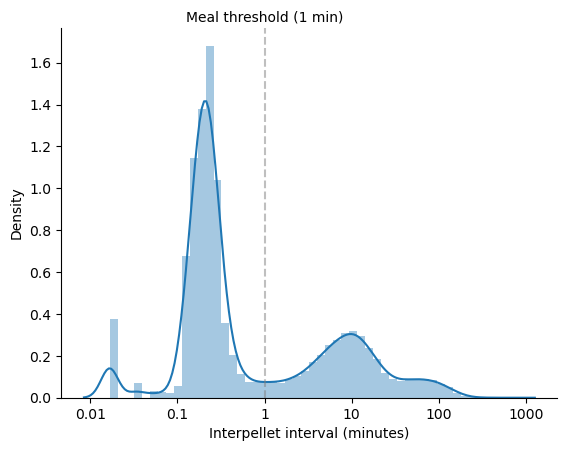

In [9]:
f, ax = plt.subplots()
data = sns.distplot(trans_ipis)
ax.set_xlabel("Interpellet interval (minutes)")
ax.set_xticks([-2, -1, 0, 1, 2, 3], labels=["0.01", "0.1", "1", "10", "100", "1000"])

ax.axvline(0, linestyle="--", color="grey", alpha=0.5)
ax.text(0,1.8, "Meal threshold (1 min)", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig("..\\results\\ipi_ff.png")

In [10]:
def make_ff_df(df, mouse, diet):
    """
    Takes df of pellets - time and IPIs - and returns row for collated df
    """
    out = pd.DataFrame.from_dict({"mouse": [mouse],
                                  "diet": [diet],
                                  "n_pellets": [len(df)],
                                  "n_meals": (df > 60).sum(),
                                  "session_time": (df.index[-1] - df.index[0]).total_seconds() / 60,
                                  "short_ipis": (df < 5).sum()
                                  })

    return (out
           .assign(meal_freq=lambda df_: 1 / (df_.session_time / df_.n_meals) * 60 * 24,
                   meal_size=lambda df_: df_.n_pellets / df_.n_meals,
                   )
           .astype({"diet": "category",
                    "n_pellets": "uint16",
                    "n_meals": "uint16"}))

ff = pd.DataFrame()

for key, val in ff_dict.items():
    
    pellets = val["pellets"]
    mouse = val["mouse"]
    diet = val["diet"]
    ff = pd.concat([ff, make_ff_df(pellets, mouse, diet)])
    
ff.reset_index(drop=True, inplace=True);


In [11]:
ff.sample(5)

,mouse,diet,n_pellets,n_meals,session_time,short_ipis,meal_freq,meal_size
6,FEDXA04,PR,1499,539,10074.483333,100,77.042164,2.781076
40,FEDXB10,NR,1498,601,10113.366667,37,85.573877,2.492512
24,FEDXB01,PR,1393,603,9975.383333,96,87.046279,2.310116
28,FEDXB03,PR,1486,635,10133.483333,83,90.235506,2.340157
42,FEDXB11,NR,1269,626,10080.816667,81,89.421327,2.027157


In [12]:
ff.groupby(by=["mouse", "diet"])

In [13]:
n_pellets = pd.pivot_table(ff, values="n_pellets", index="mouse", columns="diet")
meal_size = pd.pivot_table(ff, values="meal_size", index="mouse", columns="diet")
meal_freq = pd.pivot_table(ff, values="meal_freq", index="mouse", columns="diet")

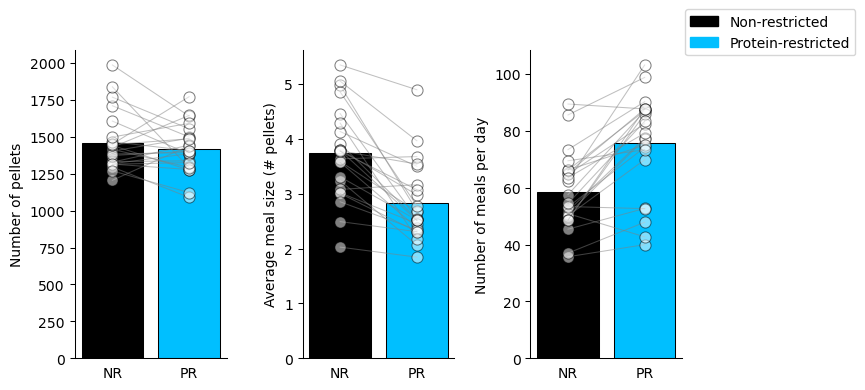

In [14]:
fed_cols = ["black", "deepskyblue"]
f, ax = plt.subplots(ncols = 3,
                     figsize=(9,4),
                     gridspec_kw={"wspace": 0.5, "right": 0.8})

for axis, vals in zip(ax, [n_pellets, meal_size, meal_freq]):
    tp.barscatter([vals.NR, vals.PR],
                  paired=True,
                  barfacecolor=fed_cols,
                  barfacecolor_option="individual",
                  barlabels=["NR", "PR"],
                  sc_kwargs={"alpha": 0.5},
                  ax=axis);
    
ax[0].set_ylabel("Number of pellets")
ax[1].set_ylabel("Average meal size (# pellets)")
ax[2].set_ylabel("Number of meals per day")

# legend
NR_patch = mpatches.Patch(color=fed_cols[0], label='Non-restricted')
PR_patch = mpatches.Patch(color=fed_cols[1], label='Protein-restricted')

ax[2].legend(handles=[NR_patch, PR_patch],
             bbox_to_anchor=(1, 1),
             bbox_transform=f.transFigure)

#f.savefig("..\\results\\fed_ff_mode.png")

In [17]:
HOARDING_METAFILE = "..\\FEDProtein_METAFILE.xls"
df = pd.read_excel(HOARDING_METAFILE, sheet_name="HOARDING")

def tweak_hoarding(df):
    
    return (df
            .drop(columns=["day0", "day1", "day2"])
            .rename(columns={"mouseid": "mouse"})
            .assign(
                    diet=["PRNR"] * 6 + ["NRPR"] * 6 + ["PRNR"] * 6 + ["NRPR"] * 5)
            .astype({"diet": "category"})
            .astype({"day{}".format(n): "int8" for n in range(3,17)})
           )
    
hoard = tweak_hoarding(df)


C:\Users\hta031\AppData\Local\Temp\ipykernel_49476\446871618.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  hoard_grouped = pd.pivot_table(hoard, index=["mouse", "diet"])
C:\Users\hta031\AppData\Local\Temp\ipykernel_49476\446871618.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  PRNR = hoard.groupby(by="diet").mean(numeric_only=True).loc["PRNR"]
C:\Users\hta031\AppData\Local\Temp\ipykernel_49476\446871618.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

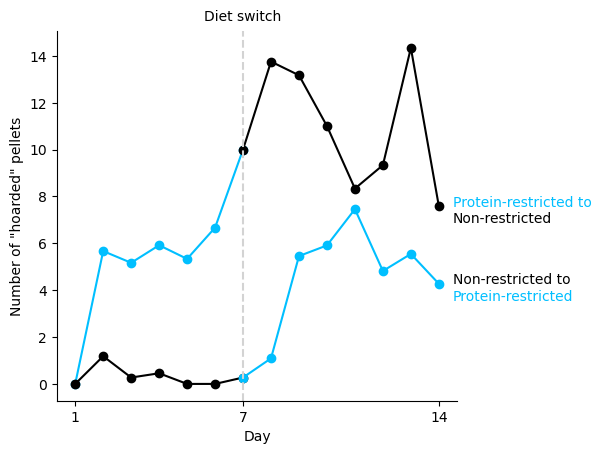

In [22]:
hoard_grouped = pd.pivot_table(hoard, index=["mouse", "diet"])

fed_cols = ["black", "deepskyblue"]

PRNR = hoard.groupby(by="diet").mean(numeric_only=True).loc["PRNR"]
NRPR = hoard.groupby(by="diet").mean(numeric_only=True).loc["NRPR"]

PRNR_sem = hoard.groupby(by="diet").sem(numeric_only=True).loc["PRNR"]

ph1_x = range(0,7)
ph2_x = range(6,14)

f, ax = plt.subplots(gridspec_kw={"right": 0.75})

ax.plot(ph1_x, PRNR[:7], color=fed_cols[1], marker="o")
ax.plot(ph2_x, PRNR[6:], color=fed_cols[0], marker="o")

ax.plot(ph1_x, NRPR[:7], color=fed_cols[0], marker="o")
ax.plot(ph2_x, NRPR[6:], color=fed_cols[1], marker="o")

ax.text(13.5, PRNR[-1], "Protein-restricted to", color=fed_cols[1])
ax.text(13.5, PRNR[-1]-0.7, "Non-restricted", color=fed_cols[0])

ax.text(13.5, NRPR[-1], "Non-restricted to", color=fed_cols[0])
ax.text(13.5, NRPR[-1]-0.7, "Protein-restricted", color=fed_cols[1])

ax.set_ylabel('Number of "hoarded" pellets')
ax.set_xticks([0, 6, 13], labels=["1", "7", "14"])
ax.set_xlabel("Day")


ax.axvline(6, color="lightgrey", linestyle="--")
ax.text(6, 15.5, "Diet switch", ha="center")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

f.savefig("..\\results\\hoarding.png")


In [12]:
# read in metafile and put pellets dataframe in keys of a dict
METAFILE = "..\\FEDXA DATA SHEETS METAFILE.xls"
rows, header = tp.metafilereader(METAFILE, sheetname="METAFILE")

def tweak_eco(df, event="Left"):
    
    return (df
            .rename(columns={"MM:DD:YYYY hh:mm:ss": "t"})
            .assign(t=lambda df_: pd.to_datetime(df_.t))
            .set_index("t")
            .query("Event == @event")
            .loc[:,"FR"]           
           )

eco_dict = {}
for row in rows:
    file, mouse, diet, mode, sex, order = row
    if (mode == "ECO") and (diet in ["PR", "RICH"]):
        key = "_".join([mouse, diet])
        eco_dict[key] = {}
        eco_dict[key]["mouse"] = mouse
        eco_dict[key]["diet"] = diet
        eco_dict[key]["sex"] = sex
        eco_dict[key]["FR"] = tweak_eco(pd.read_csv(os.path.join(DATA_FOLDER, file)))
    

File is excel file. Making csv metafile first


In [13]:
circa_eco = pd.DataFrame()

eco_pellets_dict = {}
for row in rows:
    file, mouse, diet, mode, sex, order = row
    if (mode == "ECO") and (diet in ["PR", "RICH"]):
        key = "_".join([mouse, diet])
        eco_pellets_dict[key] = {}
        eco_pellets_dict[key]["mouse"] = mouse
        eco_pellets_dict[key]["diet"] = diet
        eco_pellets_dict[key]["sex"] = sex
        eco_pellets_dict[key]["FR"] = tweak_eco(pd.read_csv(os.path.join(DATA_FOLDER, file)), event="Pellet")




In [14]:
def make_circa_df(pellets, mouse, rename_col="ipi"):
    
    return (pellets
            .resample("H")
            .count()
            .reset_index()
            .assign(t=lambda df_: [dt.replace(day=1, month=1) for dt in df_.t])
            .set_index("t")
            .resample("H").mean()
            .rename(columns={rename_col: mouse})
           )

circa = pd.DataFrame()

for key, val in ff_dict.items():
    
    pellets = val["pellets"]
    mouse = val["mouse"]
    diet = val["diet"]
    circa = pd.concat([circa, make_circa_df(pellets, mouse)], axis=1)

circa.mean(axis=1)

t
2022-01-01 00:00:00    14.431677
2022-01-01 01:00:00    13.049689
2022-01-01 02:00:00     9.354037
2022-01-01 03:00:00     7.860248
2022-01-01 04:00:00     6.993789
2022-01-01 05:00:00     7.431677
2022-01-01 06:00:00    10.295031
2022-01-01 07:00:00     8.661491
2022-01-01 08:00:00     5.178571
2022-01-01 09:00:00     6.700311
2022-01-01 10:00:00     6.325052
2022-01-01 11:00:00     5.194229
2022-01-01 12:00:00     4.609213
2022-01-01 13:00:00     3.349379
2022-01-01 14:00:00     2.701863
2022-01-01 15:00:00     3.427536
2022-01-01 16:00:00     3.749482
2022-01-01 17:00:00     4.372671
2022-01-01 18:00:00     6.133540
2022-01-01 19:00:00     9.944099
2022-01-01 20:00:00    14.978261
2022-01-01 21:00:00    17.220497
2022-01-01 22:00:00    17.015528
2022-01-01 23:00:00    16.236025
Freq: H, dtype: float64

In [15]:

circa_eco = pd.DataFrame()
circa_eco_pokes = pd.DataFrame()

for key, val in eco_pellets_dict.items():
    
    pellets = val["FR"]
    mouse = val["mouse"]
    diet = val["diet"]
    circa_eco = pd.concat([circa_eco, make_circa_df(pellets, mouse, rename_col="FR")], axis=1)
    
for key, val in eco_dict.items():
    
    pokes = val["FR"]
    mouse = val["mouse"]
    diet = val["diet"]
    circa_eco_pokes = pd.concat([circa_eco_pokes, make_circa_df(pokes, mouse, rename_col="FR")], axis=1)

circa_eco_pokes.sum(axis=1).div(12)

t
2022-01-01 00:00:00    235.527778
2022-01-01 01:00:00    159.055556
2022-01-01 02:00:00    125.611111
2022-01-01 03:00:00     60.861111
2022-01-01 04:00:00     39.277778
2022-01-01 05:00:00     58.805556
2022-01-01 06:00:00     82.638889
2022-01-01 07:00:00     94.416667
2022-01-01 08:00:00     26.194444
2022-01-01 09:00:00     73.527778
2022-01-01 10:00:00     50.500000
2022-01-01 11:00:00     28.097222
2022-01-01 12:00:00     28.652778
2022-01-01 13:00:00     19.194444
2022-01-01 14:00:00     25.333333
2022-01-01 15:00:00     12.305556
2022-01-01 16:00:00     14.972222
2022-01-01 17:00:00     21.305556
2022-01-01 18:00:00     28.166667
2022-01-01 19:00:00     44.083333
2022-01-01 20:00:00    106.666667
2022-01-01 21:00:00    181.694444
2022-01-01 22:00:00    245.250000
2022-01-01 23:00:00    226.666667
Freq: H, dtype: float64

In [16]:
eco_dict.keys()

dict_keys(['FEDXA01_PR', 'FEDXA01_RICH', 'FEDXA02_PR', 'FEDXA02_RICH', 'FEDXA03_PR', 'FEDXA03_RICH', 'FEDXA04_PR', 'FEDXA04_RICH', 'FEDXA05_PR', 'FEDXA05_RICH', 'FEDXA06_PR', 'FEDXA06_RICH', 'FEDXA07_PR', 'FEDXA07_RICH', 'FEDXA08_PR', 'FEDXA08_RICH', 'FEDXA09_PR', 'FEDXA09_RICH', 'FEDXA10_PR', 'FEDXA10_RICH', 'FEDXA11_PR', 'FEDXA11_RICH', 'FEDXA12_PR', 'FEDXA12_RICH'])

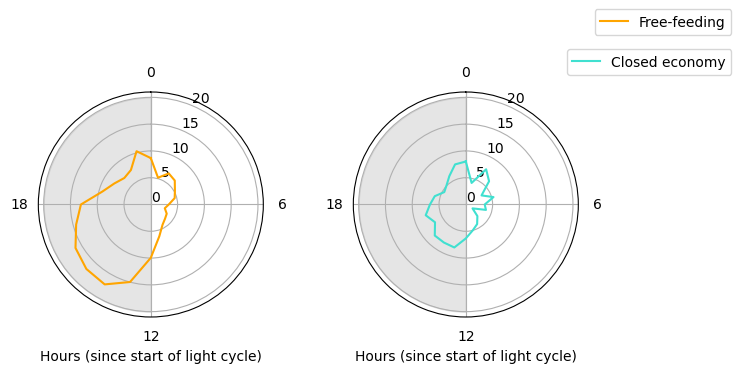

In [26]:
def make_polar_plot(y, ax, color="orange", t_offset=7, label="Free-feeding", yticks=[0,5,10,15,20]):
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)

    x = np.linspace(0, 2*np.pi, 25)

    y = y[t_offset:] + y[:t_offset]
    y = y + [y[0]]

    ax.plot(x,y,label=label, color=color)

    ax.set_xlabel('Hours (since start of light cycle)')
    ax.set_xticks(np.linspace(0, 2*np.pi, 5))
    ax.set_xticklabels([0, 6, 12, 18, None])

    ax.set_yticks(yticks)

    off = 12
    theta = (off/24)*2*np.pi
    ax.fill_between(np.linspace(theta, 2*np.pi, 100), 0, ax.get_rmax(),
                    color='gray',alpha=.2,zorder=0)
    


f, ax = plt.subplots(figsize=(8,4), ncols=2,
                     subplot_kw=dict(polar=True),
                     gridspec_kw=dict(right=0.8, wspace=0.4))
make_polar_plot(circa.mean(axis=1).to_list(), ax[0])
make_polar_plot(circa_eco.sum(axis=1).div(12).to_list(), ax[1], color="turquoise", label="Closed economy")
# ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')

ax[0].legend(bbox_to_anchor=(1,1),
            bbox_transform=f.transFigure)
ax[1].legend(bbox_to_anchor=(1,0.9),
            bbox_transform=f.transFigure)


f.savefig("..\\results\\chronograms.png")

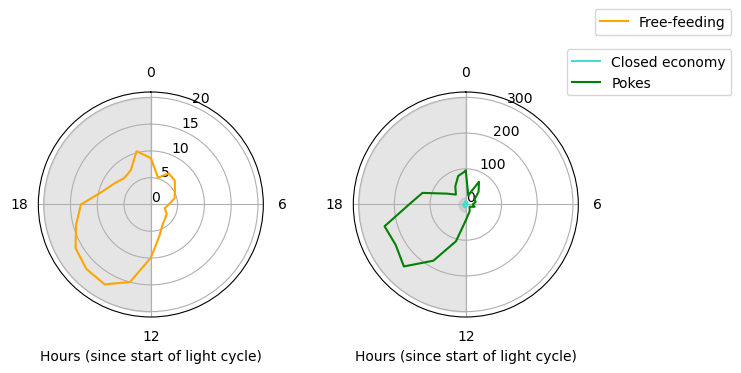

In [29]:
f, ax = plt.subplots(figsize=(8,4), ncols=2,
                     subplot_kw=dict(polar=True),
                     gridspec_kw=dict(right=0.8, wspace=0.4))

make_polar_plot(circa.mean(axis=1).to_list(), ax[0])

make_polar_plot(circa_eco.sum(axis=1).div(12).to_list(), ax[1], color="turquoise", label="Closed economy")


make_polar_plot(circa_eco_pokes.sum(axis=1).div(12).to_list(), ax[1], color="green", label="Pokes", yticks=[0,100,200,300])

# ax[1].legend(bbox_to_anchor=(1,1),loc='upper left')

ax[0].legend(bbox_to_anchor=(1,1),
            bbox_transform=f.transFigure)
ax[1].legend(bbox_to_anchor=(1,0.9),
            bbox_transform=f.transFigure)

f.savefig("..\\results\\chronograms_w_pokes.png")

In [18]:
def get_FR_reset_index(df):
    
    return (df
            .reset_index()
            .query("FR == 1")
            .reset_index()
            ["index"]   
           )

def get_breakpoints(df):
    
    return (df
            .iloc[get_FR_reset_index(df)[1:] - 1]
           )

def make_eco_df(df, mouse, diet):
    """
    Takes df of FRs and returns row for collated df
    """
    out = pd.DataFrame.from_dict({"mouse": [mouse],
                                  "pellet_type": [diet],
                                  "n_pellets": [(df == 1).sum()],
                                  "breakpoint": [np.mean(get_breakpoints(df))]
                                 }
                                )

    return (out
           .astype({"pellet_type": "category",
                    "n_pellets": "uint16",
                    })
           )
                                  
eco_df = pd.DataFrame()

for key, val in eco_dict.items():
    
    fr = val["FR"]
    mouse = val["mouse"]
    diet = val["diet"]
    eco_df = pd.concat([eco_df, make_eco_df(fr, mouse, diet)])
    
eco_df.reset_index(drop=True, inplace=True);
eco_df = eco_df.assign(diet=["NR"] * 12 + ["PR"] * 12)


In [19]:
n_pellets = pd.pivot_table(eco_df, values="n_pellets", index=["mouse", "diet"], columns="pellet_type")
breakpoint = pd.pivot_table(eco_df, values="breakpoint", index=["mouse", "diet"], columns="pellet_type")
# meal_freq = pd.pivot_table(ff, values="meal_freq", index="mouse", columns="diet")

In [20]:
breakpoint.xs("NR", level=1)

pellet_type,PR,RICH
mouse,,
FEDXA01,17.277778,3.500000
FEDXA02,15.588235,10.363636
FEDXA03,17.388889,3.769231
FEDXA04,18.703704,6.103448
FEDXA05,15.235294,5.071429
FEDXA06,21.833333,4.290323


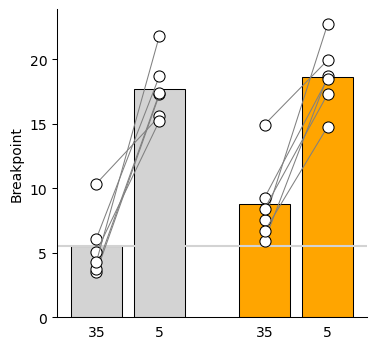

In [21]:
fed_cols = ["lightgrey", "lightgrey", "orange", "orange"]
f, ax = plt.subplots(ncols = 1,
                     figsize=(4,4),
                     gridspec_kw={"wspace": 0.5})


NR = breakpoint.xs("NR", level=1)
PR = breakpoint.xs("PR", level=1)

tp.barscatter([[NR.RICH, NR.PR],
               [PR.RICH, PR.PR]
              ],
              paired=True,
              barfacecolor=fed_cols,
              barfacecolor_option="individual",
              barlabels=["35", "5", "35", "5"],
              ax=ax);


ax.set_ylabel("Breakpoint")

ax.axhline(5.5, color="lightgrey")

f.savefig("..\\results\\fed_breakpoint.png")

<Axes: ylabel='Density'>

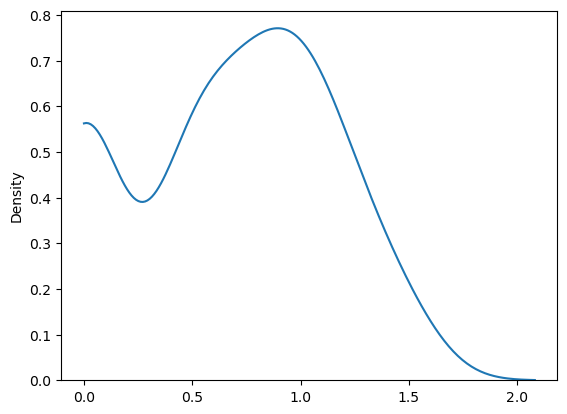

In [22]:
f, ax = plt.subplots()

sns.kdeplot(data = np.log10(pellets.values),
            bw_adjust=1,
            clip=(0,pellets.max()),
#             log_scale=True
           )
# ax.hist(pellets.values)
# ax.set_xlim([0,1000]);

In [88]:
# want to link hoarding to short pellet times
# try correlation between number of hoarded pellets and IPIs<5s (then try varying time threshold)

short_ipis = pd.pivot_table(ff, values="short_ipis", index="mouse", columns="diet")

In [90]:
short_ipis

diet,NR,PR
mouse,,
FEDXA01,30,53
FEDXA02,44,54
FEDXA03,84,116
FEDXA04,83,100
FEDXA05,18,32
FEDXA06,118,148
FEDXA07,55,34
FEDXA08,59,44
FEDXA09,34,18


In [91]:
hoarding

NameError: name 'hoarding' is not defined

In [110]:
def get_short_ipis(ipis):
    return (ipis < 5).sum()

(ff_dict["FEDXA10_PR"]["pellets"]
 .dropna()
 .resample("D")
 .apply(get_short_ipis)
)

t
2022-05-03     6
2022-05-04     6
2022-05-05    11
2022-05-06     7
2022-05-07     9
2022-05-08     8
2022-05-09     5
2022-05-10     0
Freq: D, Name: ipi, dtype: int64

In [116]:
(hoard
 .set_index("mouse")
 .rename(columns)

,day3,day4,day5,day6,day7,day8,day9,day10,day11,day12,day13,day14,day15,day16,diet
mouse,,,,,,,,,,,,,,,
FEDXA01,0,0,0,0,0,0,12,10,5,17,10,10,11,8,PRNR
FEDXA02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,PRNR
FEDXA03,0,0,0,0,35,10,25,50,70,45,40,55,45,40,PRNR
FEDXA04,0,0,0,0,0,25,32,70,32,25,25,13,40,14,PRNR
FEDXA05,0,0,0,0,25,30,26,30,45,45,25,20,38,13,PRNR
FEDXA06,0,0,0,0,0,5,0,0,0,0,0,0,0,0,PRNR
FEDXA07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NRPR
FEDXA08,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NRPR
FEDXA09,0,0,0,0,0,0,0,0,0,0,5,7,27,15,NRPR
